In [1]:
import pandas as pd
import numpy as np
#from google.colab import drive

#drive.mount('/content/drive')
data_path = './data'
dataDict = {}
for year in range(1992,2021):
    if year == 2004:
        continue
    nextYear = year + 1
    nextYear = str(nextYear)
    nextYear = nextYear[2:]
    data = pd.read_csv(f'{data_path}/NHL_Data/{str(year)}-{nextYear}.csv')
    playoffList = data['Playoff'].tolist()
  
    pointsList = data['P'].tolist()
    for index in range(len(playoffList)):
        if index == 0:
            continue
        if playoffList[index] == 0 and playoffList[index-1] == 1:
            counter = 1
            while pointsList[index + counter] >= (pointsList[index] - 5):
                playoffList[index + counter] = 2
                counter += 1
            while (pointsList[index] + 5) >= pointsList[index - counter]:
                playoffList[index - counter] = 2
                counter += 1
            break
    data['Playoff']=playoffList  
    dataDict[year] = data

In [2]:
#Combine all the individual season data frames into one
allData = pd.concat(dataDict.values() ,axis=0)
#Remove unnecessary columns that won't be used as features in the model
allData.drop(['W', 'L', 'T', 'OT', 'P', 'GP', 'P%', 'RW', 'ROW', 'S/O Win', 'GF', 'GA'], axis=1, inplace=True)
allData.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Team,Season,GF/GP,GA/GP,PP%,PK%,Net PP%,Net PK%,Shots/GP,SA/GP,FOW%,Conference,Playoff
0,0,0,0,0,Pittsburgh Penguins,19921993,4.37,3.19,23.9,83.2,19.6,87.9,32.4,30.7,--,East,1
1,1,1,1,1,Boston Bruins,19921993,3.95,3.19,20.9,83.1,19.1,87.7,34.4,26.1,--,East,1
2,2,2,2,2,Chicago Blackhawks,19921993,3.32,2.74,18.4,83.5,16.5,86.3,32.2,27.3,--,West,1
3,3,3,3,3,Quebec Nordiques,19921993,4.18,3.57,21.8,80.6,18.3,85.4,30.0,30.3,--,East,1
4,4,4,4,4,Detroit Red Wings,19921993,4.39,3.33,24.9,81.2,22.7,85.5,32.9,28.9,--,East,1


In [3]:
import random
fowValues = []
for year in range(1997,2021):
    if year == 2004:
        continue
    nextYear = year + 1
    season = allData.loc[allData['Season'] == int((str(year) + str(nextYear)))]
    fowValues.append((round(season.median()['FOW%'], 1)))

#Fill empty values with a median FOW% result from another season
allData=allData.replace(to_replace = '--', value = random.choice(fowValues))
allData.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Team,Season,GF/GP,GA/GP,PP%,PK%,Net PP%,Net PK%,Shots/GP,SA/GP,FOW%,Conference,Playoff
0,0,0,0,0,Pittsburgh Penguins,19921993,4.37,3.19,23.9,83.2,19.6,87.9,32.4,30.7,50.2,East,1
1,1,1,1,1,Boston Bruins,19921993,3.95,3.19,20.9,83.1,19.1,87.7,34.4,26.1,50.2,East,1
2,2,2,2,2,Chicago Blackhawks,19921993,3.32,2.74,18.4,83.5,16.5,86.3,32.2,27.3,50.2,West,1
3,3,3,3,3,Quebec Nordiques,19921993,4.18,3.57,21.8,80.6,18.3,85.4,30.0,30.3,50.2,East,1
4,4,4,4,4,Detroit Red Wings,19921993,4.39,3.33,24.9,81.2,22.7,85.5,32.9,28.9,50.2,East,1


In [4]:
#import goalies data
goaliesDict={}
star_goaliesDict = {}
for year in range(1992,2021):
    if year == 2004:
        continue
    nextYear = year + 1
    nextYear = str(nextYear)
    nextYear = nextYear[2:]
    data = pd.read_excel(f'{data_path}/goalies/{str(year)}-{nextYear}.xlsx')
    #Fill empty values with 0
    data=data.replace(to_replace = '--', value = 0)
    #GAA's value was adjusted to the same value range as Sv% [0,1] 
    data.GAA=data.GAA/data.GAA.max()
    #Sv% is positive for goalie and GAA is negtive, goalie performance consider equal weight of each feature
    data['goalie_performance']=data['Sv%']-data.GAA
    #sorted by goalie performance and keep first ten as star players 
    data=data.sort_values(by='goalie_performance',ascending=False)
    data=data.reset_index(drop=True)
    #drop unnecessary columns that won't be used as features in the model
    data.drop(['S/C', 'GP', 'GS', 'W', 'L', 'T', 'OT','SA', 'Svs', 'GA', 'Sv%', 'GAA', 'TOI', 'SO', 'G', 'A', 'P', 'PIM'], axis=1, inplace=True)
    star_goalies=data.iloc[0:10]
    goaliesDict[year]=data
    star_goaliesDict[year] =star_goalies
#Combine all the individual season data frames into one
all_star_goalies = pd.concat(star_goaliesDict.values() ,axis=0)
all_goalies= pd.concat(goaliesDict.values() ,axis=0)
print(all_star_goalies.shape)
print(all_goalies.shape)

(280, 4)
(2422, 4)


In [5]:
#import skaters data
all_skatersDict = {}
for year in range(1992,2021):
    if year == 2004:
        continue
    nextYear = year + 1
    nextYear = str(nextYear)
    nextYear = nextYear[2:]
    oneseasonDict={}
#oneseason's data are saved in seperate xlsx file, then use for loop to combine them
    for i in range(1,11):
        try:
            oneseasonDict[i] = pd.read_excel(f'{data_path}/skaters/{str(year)}-{nextYear}/{i}.xlsx')
        except:
            continue
    #Combine all the individual data sheets frames into one
    oneseason=pd.concat(oneseasonDict.values() ,axis=0)
    
    all_skatersDict[year]= pd.concat(oneseasonDict.values() ,axis=0)

#get Defensemen performance data of Defense skaters and obtain star defensers roster
defenseDict={}
star_defenseDict = {}
for year in range(1992,2021):
    if year == 2004:
        continue
    data = all_skatersDict[year]
    data=data[data.Pos=='D']
    #Fill empty values with 0
    data=data.replace(to_replace = '--', value = 0)
    data.drop(['S/C', 'Pos', 'GP', 'A', 'P','EVG', 'EVP', 'PPG', 'PPP', 'SHG', 'SHP', 'OTG', 'GWG','TOI/GP', 'FOW%'], axis=1, inplace=True)
    # Defensemen performance combine skaters features status of (+/-), points per game, PIM, goals, shots, shots%, all the features values are set in [0,1] and handle in equal weight
    data.G=data.G/data.G.max()
    data['+/-']=data['+/-']/data['+/-'].max()
    data.PIM=data.PIM/data.PIM.max()
    data['P/GP']=data['P/GP']/data['P/GP'].max()
    data['S']=data['S']/data['S'].max()
    data['S%'] = pd.to_numeric(data['S%'],errors='coerce')
    data['S%']=data['S%']/data['S%'].max()
    data['Defense']=data.G+data['+/-']+data.PIM+data['P/GP']+data['S']+ data['S%']
    #sorted by defense performance and keep first 20 each season as star players 
    data=data.sort_values(by='Defense',ascending=False)
    data=data.reset_index(drop=True)
    star_defense=data.iloc[0:20]
    defenseDict[year]=data
    star_defenseDict[year] =star_defense

#get forward performance data of forward skaters and obtain star forwarder's roster
forwardDict={}
star_forwardDict = {}
for year in range(1992,2021):
    if year == 2004:
        continue
    data = all_skatersDict[year]
    data=data[data.Pos!='D']
    #Fill empty values with 0
    data=data.replace(to_replace = '--', value = 0)
    data.drop(['S/C', 'Pos', 'GP', 'A', 'P','EVG', 'EVP', 'PPG', 'PPP', 'SHG', 'SHP', 'OTG', 'GWG','TOI/GP', 'FOW%'], axis=1, inplace=True)
    # forward performance combine skaters features status of(+/-), points per game, PIM, goals, shots, shots%, all the features values are set in [0,1] and handle them in equal weight
    data.G=data.G/data.G.max()
    data['+/-']=data['+/-']/data['+/-'].max()
    data.PIM=data.PIM/data.PIM.max()
    data['P/GP']=data['P/GP']/data['P/GP'].max()
    data['S']=data['S']/data['S'].max()
    data['S%'] = pd.to_numeric(data['S%'],errors='coerce')
    data['S%']=data['S%']/data['S%'].max()
    data['Forward']=data.G+data['+/-']+data.PIM+data['P/GP']+data['S']+ data['S%']
    #sorted by forward performance and keep first 20 each season as star players 
    data=data.sort_values(by='Forward',ascending=False)
    data=data.reset_index(drop=True)
    star_forward=data.iloc[0:20]
    forwardDict[year]=data
    star_forwardDict[year] =star_forward

#combine gollies, defense performance and forward performance of skaters by teams
skatersDict={}
for year in range(1992,2021):
    if year == 2004:
        continue
    skaters=pd.concat([forwardDict[year],defenseDict[year],goaliesDict[year]],axis=0)
    skaters.drop(['+/-', 'G', 'P/GP', 'S','S%'], axis=1, inplace=True)
    skaters=skaters.fillna(0)
    skaters_manyteam=pd.DataFrame()
    #skaters belong to two or three teams, copy his performance for each team, then calculate team's average performance
    for i in skaters.Team.unique():
        if len(i)>6:
            j=i.split(',')
            r2=skaters.loc[skaters.Team==i]
            r3=skaters.loc[skaters.Team==i]
            skaters['Team'].replace({i: j[0]}, inplace=True)
            r2['Team'].replace({i: j[1]}, inplace=True)
            skaters_manyteam=skaters_manyteam.append(r2)
            try:
               r3['Team'].replace({i: j[2]}, inplace=True) 
               skaters_manyteam=skaters_manyteam.append(r3)
            except:
                continue      
    skaters=skaters.append(skaters_manyteam)
    skatersDict[year]=skaters.groupby(['Team']).mean()
skatersDict[1992]

/home/hiipivahalko/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Season,PIM,Forward,Defense,goalie_performance
Team,,,,,
BOS,19921993,0.103733,0.527377,0.302080,0.056051
BUF,19921993,0.141639,0.582017,0.281885,0.058857
CGY,19921993,0.154408,0.597382,0.341503,0.042614
CHI,19921993,0.182986,0.486612,0.337193,0.033927
DET,19921993,0.161925,0.694144,0.358354,0.032296
EDM,19921993,0.173953,0.398556,0.222152,0.022977
HFD,19921993,0.169974,0.412875,0.142720,0.074784
LAK,19921993,0.156342,0.477479,0.297608,0.031216
MNS,19921993,0.154322,0.454400,0.180369,0.031518


In [6]:
for year in range(1992,2021):
    if year == 2004:
        continue
    star_player=pd.concat([star_goaliesDict[year],star_defenseDict[year],star_forwardDict[year]],axis=0)
    starskaters_manyteam=pd.DataFrame()
    #skaters belong to two or three teams, the number of star players should caluculated for each team separately.
    for i in star_player.Team.unique():
            if len(i)>6:
                j=i.split(',')
                r2=skaters.loc[skaters.Team==i]
                r3=skaters.loc[skaters.Team==i]
                star_player['Team'].replace({i: j[0]}, inplace=True)
                r2['Team'].replace({i: j[1]}, inplace=True)
                starskaters_manyteam=starskaters_manyteam.append(r2)
                try:
                   r3['Team'].replace({i: j[2]}, inplace=True) 
                   starskaters_manyteam=starskaters_manyteam.append(r3)
                except:
                    continue 
    star_player=star_player.append(starskaters_manyteam)
    star=star_player.Team.to_numpy()
    for i in np.unique(star):
        skatersDict[year].loc[i,'star_player']=np.sum(star==i)
skaters_performance_perteam= pd.concat(skatersDict.values() ,axis=0)
skaters_performance_perteam=skaters_performance_perteam.reset_index()

In [7]:
#creat a dictionary contain teams' name and abbreviation
import requests
import json

teamname={}
for i in range(1,56):
    sub_req = "https://statsapi.web.nhl.com/api/v1/teams/"+str(i)
    sub_r = requests.get(sub_req)
    team_json = sub_r.text
    team_data = json.loads(team_json)
    abbre=team_data['teams'][0]['abbreviation']
    name=team_data['teams'][0]['name']
    teamname[abbre]=name
#replace teams name from abbreviation to whole name
skaters_performance_perteam['Team'].replace(teamname, inplace=True)
skaters_performance_perteam.head

<bound method NDFrame.head of                      Team    Season       PIM   Forward   Defense  \
0           Boston Bruins  19921993  0.103733  0.527377  0.302080   
1          Buffalo Sabres  19921993  0.141639  0.582017  0.281885   
2          Calgary Flames  19921993  0.154408  0.597382  0.341503   
3      Chicago Blackhawks  19921993  0.182986  0.486612  0.337193   
4       Detroit Red Wings  19921993  0.161925  0.694144  0.358354   
..                    ...       ...       ...       ...       ...   
808   Toronto Maple Leafs  20202021  0.138583  0.650819  0.316824   
809     Vancouver Canucks  20202021  0.170168  0.376906  0.268414   
810  Vegas Golden Knights  20202021  0.149605  0.794233  0.509032   
811         Winnipeg Jets  20202021  0.171198  0.628173  0.306255   
812   Washington Capitals  20202021  0.200142  0.671859  0.367669   

     goalie_performance  star_player  
0              0.056051          4.0  
1              0.058857          3.0  
2              0.042614 

In [8]:
#combine skaters and teams dataframe
team_data=pd.merge(skaters_performance_perteam,allData,on=['Team','Season'])
team_data.drop(['Unnamed: 0'], axis=1, inplace=True)
team_data=team_data.fillna(0)
team_data=team_data.replace(to_replace = '--', value = 0)

team_data.to_csv('./preprocessed_data.csv', index=False)
team_data.iloc[0]

Team                  Boston Bruins
Season                     19921993
PIM                        0.103733
Forward                    0.527377
Defense                     0.30208
goalie_performance         0.056051
star_player                     4.0
Unnamed: 0.1                      1
Unnamed: 0.1.1                    1
Unnamed: 0.1.1.1                  1
GF/GP                          3.95
GA/GP                          3.19
PP%                            20.9
PK%                            83.1
Net PP%                        19.1
Net PK%                        87.7
Shots/GP                       34.4
SA/GP                          26.1
FOW%                           50.2
Conference                     East
Playoff                           1
Name: 0, dtype: object

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X=team_data[['PIM', 'Forward', 'Defense', 'goalie_performance',
       'star_player', 'GF/GP', 'GA/GP', 'PP%', 'PK%', 'Net PP%', 'Net PK%',
       'Shots/GP', 'SA/GP', 'FOW%']]
y=team_data['Playoff']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("Accuracy %2.3f" % acc)

Accuracy 0.730


LinearRegression Accuracy 0.644
        Feature             P           F
1       Forward  4.944006e-34  162.373951
2       Defense  1.014332e-30  144.353215
6         GA/GP  1.569977e-20   91.083889
5         GF/GP  4.054116e-18   78.951420
9       Net PP%  1.762124e-15   65.893385
4   star_player  4.372959e-14   59.081162
7           PP%  8.424605e-14   57.698194
11     Shots/GP  1.039768e-12   52.423418
12        SA/GP  1.617364e-10   41.955941
10      Net PK%  4.707537e-09   35.064671
8           PK%  3.281116e-08   31.135295
13         FOW%  1.041102e-04   15.210826
0           PIM  6.679907e-04   11.666510
Feature: 0, Score: -0.40480
Feature: 1, Score: 0.86603
Feature: 2, Score: 0.84948
Feature: 3, Score: -0.97924
Feature: 4, Score: -0.07316
Feature: 5, Score: 0.38393
Feature: 6, Score: -0.50496
Feature: 7, Score: 0.00759
Feature: 8, Score: 0.01354
Feature: 9, Score: 0.00740
Feature: 10, Score: -0.00868
Feature: 11, Score: 0.02045
Feature: 12, Score: -0.00268
Feature: 13, Score: 

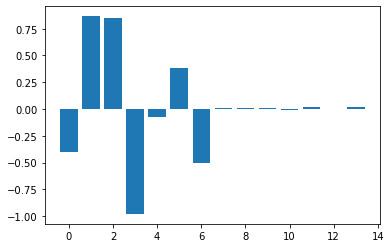

In [10]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn import linear_model, model_selection, feature_selection

# define the model
linereg = LinearRegression()
# fit the model
linereg.fit(X_train, y_train)
y_lpred = linereg.predict(X_test)
ybpred=[]
for i in y_lpred:
    if i>1.5:
        yb=2
        ybpred.append(yb)
    elif i<=0.9:
        yb=0
        ybpred.append(yb)
    else:
        yb=1
        ybpred.append(yb)
acc=accuracy_score(y_test, ybpred)
print("LinearRegression Accuracy %2.3f" % acc)
p_values = pd.DataFrame()
features=['PIM', 'Forward', 'Defense', 'goalie_performance','star_player', 'GF/GP', 'GA/GP', 'PP%', 'PK%', 'Net PP%', 'Net PK%', 'Shots/GP', 'SA/GP', 'FOW%']
p_values["Feature"] = ['PIM', 'Forward', 'Defense', 'goalie_performance','star_player', 'GF/GP', 'GA/GP', 'PP%', 'PK%', 'Net PP%', 'Net PK%', 'Shots/GP', 'SA/GP', 'FOW%']
p_values["P"] = feature_selection.f_regression(X[features], y)[1]
p_values["F"] = feature_selection.f_regression(X[features], y)[0]
print(p_values[p_values.P < 0.005].sort_values(by="P"))
# get importance
importance = linereg.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rdf=RandomForestClassifier(n_estimators=60)
rdf.fit(X_train, y_train)
print(accuracy_score(y_test, rdf.predict(X_test)))

0.7177914110429447


In [12]:
#function to calculate gollies and forward and defense performance, 
def goalief(data):
    #Fill empty values with 0
    data=data.replace(to_replace = '--', value = 0)
    #GAA's value was adjusted to the same value range as Sv% [0,1] 
    data.GAA=data.GAA/data.GAA.max()
    #Sv% is positive for goalie and GAA is negtive, goalie performance consider equal weight of each feature
    data['goalie_performance']=data['Sv%']-data.GAA
    #sorted by goalie performance and keep first ten as star players 
    data=data.sort_values(by='goalie_performance',ascending=False)
    data=data.reset_index(drop=True)
    #drop unnecessary columns that won't be used as features in the model
    data.drop(['S/C', 'GP', 'GS', 'W', 'L', 'T', 'OT','SA', 'Svs', 'GA', 'Sv%', 'GAA', 'TOI', 'SO', 'G', 'A', 'P', 'PIM'], axis=1, inplace=True)
    star_goalies=data.iloc[0:10]
    return data,star_goalies
def forwardf(data):
    data=data[data.Pos!='D']
        #Fill empty values with 0
    data=data.replace(to_replace = '--', value = 0)
    data.drop(['S/C', 'Pos', 'GP', 'A', 'P','EVG', 'EVP', 'PPG', 'PPP', 'SHG', 'SHP', 'OTG', 'GWG','TOI/GP', 'FOW%'], axis=1, inplace=True)
    # forward performance combine skaters features status of(+/-), points per game, PIM, goals, shots, shots%, all the features values are set in [0,1] and handle them in equal weight
    data.G=data.G/data.G.max()
    data['+/-']=data['+/-']/data['+/-'].max()
    data.PIM=data.PIM/data.PIM.max()
    data['P/GP']=data['P/GP']/data['P/GP'].max()
    data['S']=data['S']/data['S'].max()
    data['S%'] = pd.to_numeric(data['S%'],errors='coerce')
    data['S%']=data['S%']/data['S%'].max()
    data['Forward']=data.G+data['+/-']+data.PIM+data['P/GP']+data['S']+ data['S%']
    #sorted by forward performance and keep first 20 each season as star players 
    data=data.sort_values(by='Forward',ascending=False)
    data=data.reset_index(drop=True)
    star_forward=data.iloc[0:20]
    return data, star_forward

def defensef(data):
    data=data[data.Pos=='D']
    #Fill empty values with 0
    data=data.replace(to_replace = '--', value = 0)
    data.drop(['S/C', 'Pos', 'GP', 'A', 'P','EVG', 'EVP', 'PPG', 'PPP', 'SHG', 'SHP', 'OTG', 'GWG','TOI/GP', 'FOW%'], axis=1, inplace=True)
    # Defensemen performance combine skaters features status of (+/-), points per game, PIM, goals, shots, shots%, all the features values are set in [0,1] and handle in equal weight
    data.G=data.G/data.G.max()
    data['+/-']=data['+/-']/data['+/-'].max()
    data.PIM=data.PIM/data.PIM.max()
    data['P/GP']=data['P/GP']/data['P/GP'].max()
    data['S']=data['S']/data['S'].max()
    data['S%'] = pd.to_numeric(data['S%'],errors='coerce')
    data['S%']=data['S%']/data['S%'].max()
    data['Defense']=data.G+data['+/-']+data.PIM+data['P/GP']+data['S']+ data['S%']
    #sorted by defense performance and keep first 20 each season as star players 
    data=data.sort_values(by='Defense',ascending=False)
    data=data.reset_index(drop=True)
    star_defense=data.iloc[0:20]
    return data, star_defense
#function to combine players' performance and goalies performance
def combine(a,b,c):
    skaters=pd.concat([a,b,c],axis=0)
    skaters.drop(['+/-', 'G', 'P/GP', 'S','S%'], axis=1, inplace=True)
    skaters=skaters.fillna(0)
    skaters_manyteam=pd.DataFrame()
    #skaters belong to two or three teams, copy his performance for each team, then calculate team's average performance
    for i in skaters.Team.unique():
        if len(i)>6:
            j=i.split(',')
            r2=skaters.loc[skaters.Team==i]
            r3=skaters.loc[skaters.Team==i]
            skaters['Team'].replace({i: j[0]}, inplace=True)
            r2['Team'].replace({i: j[1]}, inplace=True)
            skaters_manyteam=skaters_manyteam.append(r2)
            try:
                r3['Team'].replace({i: j[2]}, inplace=True) 
                skaters_manyteam=skaters_manyteam.append(r3)
            except:
                continue      
    skaters=skaters.append(skaters_manyteam)
    return skaters.groupby(['Team']).mean()
#calculate how many star player in a team per season
def star_count(a,b,c,d):
    star_player=pd.concat([a,b,c],axis=0)
    starskaters_manyteam=pd.DataFrame()
    #skaters belong to two or three teams, the number of star players should caluculated for each team separately.
    for i in star_player.Team.unique():
        if len(i)>6:
            j=i.split(',')
            r2=skaters.loc[skaters.Team==i]
            r3=skaters.loc[skaters.Team==i]
            star_player['Team'].replace({i: j[0]}, inplace=True)
            r2['Team'].replace({i: j[1]}, inplace=True)
            starskaters_manyteam=starskaters_manyteam.append(r2)
            try:
                r3['Team'].replace({i: j[2]}, inplace=True) 
                starskaters_manyteam=starskaters_manyteam.append(r3)
            except:
                  continue 
    star_player=star_player.append(starskaters_manyteam)
    star=star_player.Team.to_numpy()
    for i in np.unique(star):
        d.loc[i,'star_player']=np.sum(star==i)
    return d


In [17]:
#drive.mount('/content/drive')
#import 2022 teams data
team2022 = pd.read_excel(f'{data_path}/2022/team.xlsx')
#Remove unnecessary columns that won't be used as features in the model
team2022.drop(['W', 'L', 'T', 'OT', 'P', 'GP', 'P%', 'RW', 'ROW', 'S/O Win', 'GF', 'GA'], axis=1, inplace=True)
#import 2022 goalies data
goalies2022=pd.read_excel(f'{data_path}/2022/goalies.xlsx')
goalie2022,star_goalies2022=goalief(goalies2022)

#2022season's player data are saved in seperate xlsx file, then use for loop to combine them
player2022Dict={}
for i in range(1,11):
    try:
        player2022Dict[i] = pd.read_excel(f'{data_path}/2022/skaters/{i}.xlsx')
    except:
        continue
    #Combine all the individual data sheets frames into one
player2022=pd.concat(oneseasonDict.values() ,axis=0)
forward2022,star_forward2022=forwardf(player2022)
defense2022,star_defense2022=defensef(player2022)
skater2022=combine(goalie2022,forward2022,defense2022)
skater2022=star_count(star_goalies2022,star_forward2022,star_defense2022,skater2022)
skater2022.drop(['Season'],axis=1, inplace=True)
skater2022=skater2022.reset_index()
skater2022['Team'].replace(teamname, inplace=True)
skater2022=skater2022.fillna(0)
skater2022.dtypes
team2022.dtypes
data2022=pd.merge(skater2022,team2022,on=['Team'])
data2022['predict']=logreg.predict(data2022[features])
data2022['Team'] = data2022['Team'].apply(lambda x : x if x != 'Montréal Canadiens' else 'Montreal Canadiens')
data2022.to_csv('./data2022.csv', index=False)
data2022['Team'].unique()

/home/hiipivahalko/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


array(['Anaheim Ducks', 'Arizona Coyotes', 'Boston Bruins',
       'Buffalo Sabres', 'Carolina Hurricanes', 'Columbus Blue Jackets',
       'Calgary Flames', 'Chicago Blackhawks', 'Colorado Avalanche',
       'Dallas Stars', 'Detroit Red Wings', 'Edmonton Oilers',
       'Florida Panthers', 'Los Angeles Kings', 'Minnesota Wild',
       'Montreal Canadiens', 'New Jersey Devils', 'Nashville Predators',
       'New York Islanders', 'New York Rangers', 'Ottawa Senators',
       'Philadelphia Flyers', 'Pittsburgh Penguins', 'Seattle Kraken',
       'San Jose Sharks', 'St. Louis Blues', 'Tampa Bay Lightning',
       'Toronto Maple Leafs', 'Vancouver Canucks', 'Vegas Golden Knights',
       'Winnipeg Jets', 'Washington Capitals'], dtype=object)